In [2]:
#notebook heavily stolen from https://github.com/mirandabryson/WH-All-Hadronic-Coffea-Tools/blob/master/cutflownotebook.ipynb
import os
import time
import glob
import re
from functools import reduce

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import pandas as pd
import uproot_methods
import awkward


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [4]:
def addRowToCutFlow(output, df, name, selection):
    '''
    add one row with name and selection for each process to the cutflow accumulator
    '''

    if selection is not None:
        output['cutflow'][name] += (sum(df['weight'][selection].flatten())*137)
    else:
        output['cutflow'][name] += (sum(df['weight'].flatten())*137)
            
def getCutFlowTable(output, outputname, lines = ['all']):
    '''
    Takes a cache and returns a formated cut-flow table of processes.
    Lines and processes have to follow the naming of the coffea processor output.
    '''
    res = pd.DataFrame([])
    for line in lines:
        res = res.append(pd.DataFrame({outputname : output['cutflow'][line]}, index=[line]))
    return res

In [41]:
# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

class WHhadProcessor(processor.ProcessorABC):
    """Processor used to find the pt rations"""
    def __init__(self):

         # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset", "Primary dataset")
        pt_axis             = hist.Bin("pt", r"$p_{T}$ (GeV)", 40, 200, 1200)
        mass_axis           = hist.Bin("mass", r" mass (GeV)", 50, 0, 250)
        eta_axis            = hist.Bin("eta", r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity", r"N", 20, 0, 20)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)

        self._accumulator = processor.dict_accumulator({
            'cutflow':              processor.defaultdict_accumulator(int),
            'number j':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number b':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number h':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number w':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number fj':            hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'met':                  hist.Hist("Counts", dataset_axis, pt_axis),
            'h mass':               hist.Hist("Counts", dataset_axis, mass_axis),
            'ht':                   hist.Hist("Counts", dataset_axis, pt_axis),
            'met2':                  hist.Hist("Counts", dataset_axis, pt_axis),            
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        
        #Jagged Arrays
        #MET
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]
        
        #leptons
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content,
            cutbased = df['Electron_cutBased'].content,
        )
        
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content, 
            eta=df['Muon_eta'].content, 
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            pdgid=df['Muon_pdgId'].content,
            mini_iso=df['Muon_miniPFRelIso_all'].content, 
            looseid =df['Muon_looseId'].content
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        
        isotracks = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            rel_iso=df['IsoTrack_pfRelIso03_all'], 
        )
        
        #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content,  
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW_MD = df['FatJet_deepTagMD_WvsQCD'].content, 
            fromW_MC = df['FatJet_deepTag_WvsQCD'].content
            
        )
        
         #ak4's
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0))
        goodjets = jets[goodjcut]
        njets = goodjets.counts
        jetpt_sorted = goodjets.pt.argsort(ascending=False)
        leadjet = goodjets[jetpt_sorted==0]
        subleadjet = goodjets[jetpt_sorted==1]
        leadjets = goodjets[jetpt_sorted <= 1]
      
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        numbjets = bjets.counts
        bjetpt = bjets.pt
        bjetpt_sorted = bjetpt.argsort(ascending=False)
        leadbjet = bjets[bjetpt_sorted==0]
        subleadbjet = bjets[bjetpt_sorted==1]
        leadbjets = bjets[bjetpt_sorted <= 1]
            
        nonbjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag<0.4184))
        nbjets = jets[nonbjcut]
        nbjetpt_sorted = nbjets.pt.argsort(ascending=False)
        leadnbjet = nbjets[nbjetpt_sorted==0]
        subleadnbjet = nbjets[nbjetpt_sorted==1]
        leadnbjets = nbjets[nbjetpt_sorted <= 1]

        
        #ak8's
        goodfjcut = (fatjets.pt > 200)
        goodfatjets = fatjets[goodfjcut]
        
        htagcut = (fatjets.pt > 200) & (fatjets.fromH > 0.8365)
        htagged = fatjets[htagcut]
        htagpt_sorted = htagged.pt.argsort(ascending=False)
        leadhtag = htagged[htagpt_sorted==0]
        subleadhtag = htagged[htagpt_sorted==1]
        leadhtags = htagged[htagpt_sorted <= 1]
        
        wtagcut_mc = ((fatjets.pt > 200) & (fatjets.fromW_MC > 0.918) & (fatjets.fromH < 0.8365))
        wtagcut_md = ((fatjets.pt > 200) & (fatjets.fromW_MD > 0.704) & (fatjets.fromH < 0.8365))
        wtagged_mc = fatjets[wtagcut_mc]
        wtagged_md = fatjets[wtagcut_md]
        wtagmcpt_sorted = wtagged_mc.pt.argsort(ascending=False)
        leadwmctag = wtagged_mc[wtagmcpt_sorted==0]
        subleadwmctag = wtagged_mc[wtagmcpt_sorted==1]
        leadwmctags = wtagged_mc[wtagmcpt_sorted <= 1]
        wtagmdpt_sorted = wtagged_md.pt.argsort(ascending=False)
        leadwmdtag = wtagged_md[wtagmdpt_sorted==0]
        subleadwmdtag = wtagged_md[wtagmdpt_sorted==1]
        leadwmdtags = wtagged_md[wtagmdpt_sorted <= 1]
 
        WmcH = leadwmctag.cross(leadhtag)
        WmcHpt_sorted = WmcH.pt.argsort(ascending=False)
        leadWmcleadH = WmcH[WmcHpt_sorted <=1]

        WmdH = leadwmdtag.cross(leadhtag)
        WmdHpt_sorted = WmdH.pt.argsort(ascending=False)
        leadWmdleadH = WmdH[WmdHpt_sorted <=1]

        #match jets
        
        leadjleadH = leadhtag.cross(leadjet)
        leadbjleadH = leadhtag.cross(leadbjet)
        leadnbjleadH = leadhtag.cross(leadnbjet)
        
        subleadjleadH = leadhtag.cross(subleadjet)
        subleadbjleadH = leadhtag.cross(subleadbjet)
        subleadnbjleadH = leadhtag.cross(subleadnbjet)
        
        leadjleadW = leadwmctag.cross(leadjet)
        leadbjleadW = leadwmctag.cross(leadbjet)
        leadnbjleadW = leadwmctag.cross(leadnbjet)
        
        subleadjleadW = leadwmctag.cross(leadjet)
        subleadbjleadW = leadwmctag.cross(leadbjet)
        subleadnbjleadW = leadwmctag.cross(leadnbjet)
        
        #angles
        
        leadjleadHDR = leadjleadH.i0.p4.delta_r(leadjleadH.i1.p4)
        leadjleadHDPhi = abs(leadjleadH.i0.p4.delta_phi(leadjleadH.i1.p4))
        leadbjleadHDR = leadbjleadH.i0.p4.delta_r(leadbjleadH.i1.p4)
        leadbjleadHDPhi = abs(leadbjleadH.i0.p4.delta_phi(leadbjleadH.i1.p4))
        leadnbjleadHDR = leadnbjleadH.i0.p4.delta_r(leadnbjleadH.i1.p4)
        leadnbjleadHDPhi = abs(leadnbjleadH.i0.p4.delta_phi(leadnbjleadH.i1.p4))
        
        subleadjleadHDR = subleadjleadH.i0.p4.delta_r(subleadjleadH.i1.p4)
        subleadjleadHDPhi = abs(subleadjleadH.i0.p4.delta_phi(subleadjleadH.i1.p4))
        subleadbjleadHDR = subleadbjleadH.i0.p4.delta_r(subleadbjleadH.i1.p4)
        subleadbjleadHDPhi = abs(subleadbjleadH.i0.p4.delta_phi(subleadbjleadH.i1.p4))
        subleadnbjleadHDR = subleadnbjleadH.i0.p4.delta_r(subleadnbjleadH.i1.p4)
        subleadnbjleadHDPhi = abs(subleadnbjleadH.i0.p4.delta_phi(subleadnbjleadH.i1.p4))
        
        leadjleadWDR = leadjleadW.i0.p4.delta_r(leadjleadW.i1.p4)
        leadjleadWDPhi = abs(leadjleadW.i0.p4.delta_phi(leadjleadW.i1.p4))
        leadbjleadWDR = leadbjleadW.i0.p4.delta_r(leadbjleadW.i1.p4)
        leadbjleadWDPhi = abs(leadbjleadW.i0.p4.delta_phi(leadbjleadW.i1.p4))
        leadnbjleadWDR = leadnbjleadW.i0.p4.delta_r(leadnbjleadW.i1.p4)
        leadnbjleadWDPhi = abs(leadnbjleadW.i0.p4.delta_phi(leadnbjleadW.i1.p4))
        
        subleadjleadWDR = subleadjleadW.i0.p4.delta_r(subleadjleadW.i1.p4)
        subleadjleadWDPhi = abs(subleadjleadW.i0.p4.delta_phi(subleadjleadW.i1.p4))
        subleadbjleadWDR = subleadbjleadW.i0.p4.delta_r(subleadbjleadW.i1.p4)
        subleadbjleadWDPhi = abs(subleadbjleadW.i0.p4.delta_phi(subleadbjleadW.i1.p4))
        subleadnbjleadWDR = subleadnbjleadW.i0.p4.delta_r(subleadnbjleadW.i1.p4)
        subleadnbjleadWDPhi = abs(subleadnbjleadW.i0.p4.delta_phi(subleadnbjleadW.i1.p4))
        
        
        #match phi
        dphi_leadj_met = abs((leadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadbj_met = abs((leadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadnbj_met = abs((leadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_subleadj_met = abs((subleadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadbj_met = abs((subleadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadnbj_met = abs((subleadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_h_met = abs((leadhtag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_w_met = abs((leadwmctag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        
        #MT      
        
        dphi_leadbs_met = abs((leadbjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        mt_b_met = np.sqrt(2*leadbjets.pt*metpt*(1-np.cos(dphi_leadbs_met)))

        
        sorted_min_mt_b_met = mt_b_met.argsort(ascending=True)
        sorted_max_mt_b_met = mt_b_met.argsort(ascending=False)
        min_mt_b_met = mt_b_met[sorted_min_mt_b_met == 0]
        max_mt_b_met = mt_b_met[sorted_max_mt_b_met == 0]

        
        #leptons
        
        one_e_cut = (electrons.pt > 10) & (abs(electrons.eta) < 2.4) & (electrons.mini_iso < 0.1) & (electrons.cutbased >= 1)
        one_e = electrons[one_e_cut]
        
        one_m_cut = (muons.pt > 10) & (abs(muons.eta) < 2.4) & (muons.looseid) & (muons.mini_iso < 0.2)
        one_m = muons[one_m_cut]
        
        one_t_cut = (taus.pt > 10) & (abs(taus.eta) < 2.4) & (taus.decaymode) & (taus.newid >= 8)
        one_t = taus[one_t_cut]
        
        veto_it_cut = (isotracks.pt > 10) & (abs(isotracks.eta) < 2.4) & ((isotracks.rel_iso < (0.1*isotracks.pt)) | (isotracks.rel_iso < 6))
        veto_it = isotracks[veto_it_cut]

        
        #softdrop mass
        hsd_cut = (htagged.softdrop > 1)
        hsd = htagged[hsd_cut]
        
        #PRESELECTION
        ht = goodjets.pt.sum()
        
        met_ps = (df['MET_pt']>250)
        njet_ps = (goodjets.counts >= 2)
        bjet_ps = (bjets.counts >= 1)
        fatjet1_ps = (goodfatjets.counts >= 1)
        fatjet2_ps = (goodfatjets.counts >= 2)
        ht_ps = (ht > 300)
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps
        h_sel =(htagged.counts > 0) 
        wmc_sel = (wtagged_mc.counts > 0) 
        l_sel = (one_e.counts + one_m.counts + one_t.counts == 1)
        it_sel = (veto_it.counts == 0)
        mt_sel = (min_mt_b_met > 200).any()
        sd_sel = (hsd.count == 1)
        
        #cumulative preselection
        
        sel1 = l_sel
        sel3 = l_sel & met_ps
        sel4 = l_sel & met_ps & ht_ps
        sel5 = l_sel & met_ps & ht_ps & njet_ps 
        sel6 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps
        sel7 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel
        sel8 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & fatjet1_ps
        sel9 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel  & fatjet2_ps
        sel10 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & fatjet2_ps & h_sel 
        sel11 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & h_sel & wmc_sel & fatjet2_ps
        sel12 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & h_sel & wmc_sel & fatjet2_ps & sd_sel

        #DEFINE VARIABLES 
        wght = df['weight'][sel9] * 60
        wght_htag = df['weight'][sel9 & h_sel] * 60

        #FILL OUTPUTS
        
        dataset = df["dataset"]
        output['number j'].fill(dataset=dataset, multiplicity = njets[sel9].flatten(), weight = wght)
        output['number b'].fill(dataset=dataset, multiplicity = numbjets[sel9].flatten(), weight = wght)
        output['number fj'].fill(dataset=dataset, multiplicity = (fatjets.counts)[sel9].flatten(), weight = wght)
        output['number h'].fill(dataset=dataset, multiplicity = (htagged.counts)[sel9].flatten(), weight = wght)
        output['number w'].fill(dataset=dataset, multiplicity = (wtagged_mc.counts)[sel9].flatten(), weight = wght)
        output['met'].fill(dataset=dataset, pt = metpt[sel9].flatten(), weight = wght)
        output['h mass'].fill(dataset=dataset, mass = leadhtag.mass[sel9 & h_sel].flatten(), weight = wght_htag)
        #output['ht'].fill(dataset=dataset, pt = ht.flatten(), weight = wght0)
        #output['met2'].fill(dataset=dataset, pt = metpt.flatten(), weight=wght0)

        #raw cutflow
        
        addRowToCutFlow(output, df, 'all', None)
        addRowToCutFlow(output, df, '+ one lepton', sel1)
        addRowToCutFlow(output, df, '+ met', sel3)
        addRowToCutFlow(output, df, '+ ht', sel4)
        addRowToCutFlow(output, df, '+ njet', sel5)
        addRowToCutFlow(output, df, '+ bjet', sel6)
        addRowToCutFlow(output, df, '+ min(mt(bs,met))', sel7)
        addRowToCutFlow(output, df, '+ fatjet >=1 ', sel8)
        addRowToCutFlow(output, df, '+ fatjet >=2 ', sel9)
        #addRowToCutFlow(output, df, '+ h > 0', sel10)
        #addRowToCutFlow(output, df, '+ w(MC) > 0', sel11)

        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [53]:
# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

class WHhadProcessor2(processor.ProcessorABC):
    """Processor used to find the pt rations"""
    def __init__(self):

         # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset", "Primary dataset")
        pt_axis             = hist.Bin("pt", r"$p_{T}$ (GeV)", 40, 200, 1200)
        mass_axis           = hist.Bin("mass", r" mass (GeV)", 50, 0, 250)
        eta_axis            = hist.Bin("eta", r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity", r"N", 20, 0, 20)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)

        self._accumulator = processor.dict_accumulator({
            'number j':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number b':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number h':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number w':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number fj':            hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'met':                  hist.Hist("Counts", dataset_axis, pt_axis),
            'h mass':               hist.Hist("Counts", dataset_axis, mass_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        
        #Jagged Arrays
        #MET
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]
        
        #leptons
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content,
            cutbased = df['Electron_cutBased'].content,
        )
        
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content, 
            eta=df['Muon_eta'].content, 
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            pdgid=df['Muon_pdgId'].content,
            mini_iso=df['Muon_miniPFRelIso_all'].content, 
            looseid =df['Muon_looseId'].content
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        
        isotracks = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            rel_iso=df['IsoTrack_pfRelIso03_all'], 
        )
        
        #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content,  
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW_MD = df['FatJet_deepTagMD_WvsQCD'].content, 
            fromW_MC = df['FatJet_deepTag_WvsQCD'].content
            
        )
        
         #ak4's
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0))
        goodjets = jets[goodjcut]
        njets = goodjets.counts
        jetpt_sorted = goodjets.pt.argsort(ascending=False)
        leadjet = goodjets[jetpt_sorted==0]
        subleadjet = goodjets[jetpt_sorted==1]
        leadjets = goodjets[jetpt_sorted <= 1]
      
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        numbjets = bjets.counts
        bjetpt = bjets.pt
        bjetpt_sorted = bjetpt.argsort(ascending=False)
        leadbjet = bjets[bjetpt_sorted==0]
        subleadbjet = bjets[bjetpt_sorted==1]
        leadbjets = bjets[bjetpt_sorted <= 1]
            
        nonbjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag<0.4184))
        nbjets = jets[nonbjcut]
        nbjetpt_sorted = nbjets.pt.argsort(ascending=False)
        leadnbjet = nbjets[nbjetpt_sorted==0]
        subleadnbjet = nbjets[nbjetpt_sorted==1]
        leadnbjets = nbjets[nbjetpt_sorted <= 1]

        
        #ak8's
        goodfjcut = (fatjets.pt > 200)
        goodfatjets = fatjets[goodfjcut]
        
        htagcut = (fatjets.pt > 200) & (fatjets.fromH > 0.8365)
        htagged = fatjets[htagcut]
        htagpt_sorted = htagged.pt.argsort(ascending=False)
        leadhtag = htagged[htagpt_sorted==0]
        subleadhtag = htagged[htagpt_sorted==1]
        leadhtags = htagged[htagpt_sorted <= 1]
        
        wtagcut_mc = ((fatjets.pt > 200) & (fatjets.fromW_MC > 0.918) & (fatjets.fromH < 0.8365))
        wtagcut_md = ((fatjets.pt > 200) & (fatjets.fromW_MD > 0.704) & (fatjets.fromH < 0.8365))
        wtagged_mc = fatjets[wtagcut_mc]
        wtagged_md = fatjets[wtagcut_md]
        wtagmcpt_sorted = wtagged_mc.pt.argsort(ascending=False)
        leadwmctag = wtagged_mc[wtagmcpt_sorted==0]
        subleadwmctag = wtagged_mc[wtagmcpt_sorted==1]
        leadwmctags = wtagged_mc[wtagmcpt_sorted <= 1]
        wtagmdpt_sorted = wtagged_md.pt.argsort(ascending=False)
        leadwmdtag = wtagged_md[wtagmdpt_sorted==0]
        subleadwmdtag = wtagged_md[wtagmdpt_sorted==1]
        leadwmdtags = wtagged_md[wtagmdpt_sorted <= 1]
 
        WmcH = leadwmctag.cross(leadhtag)
        WmcHpt_sorted = WmcH.pt.argsort(ascending=False)
        leadWmcleadH = WmcH[WmcHpt_sorted <=1]

        WmdH = leadwmdtag.cross(leadhtag)
        WmdHpt_sorted = WmdH.pt.argsort(ascending=False)
        leadWmdleadH = WmdH[WmdHpt_sorted <=1]

        #match jets
        
        leadjleadH = leadhtag.cross(leadjet)
        leadbjleadH = leadhtag.cross(leadbjet)
        leadnbjleadH = leadhtag.cross(leadnbjet)
        
        subleadjleadH = leadhtag.cross(subleadjet)
        subleadbjleadH = leadhtag.cross(subleadbjet)
        subleadnbjleadH = leadhtag.cross(subleadnbjet)
        
        leadjleadW = leadwmctag.cross(leadjet)
        leadbjleadW = leadwmctag.cross(leadbjet)
        leadnbjleadW = leadwmctag.cross(leadnbjet)
        
        subleadjleadW = leadwmctag.cross(leadjet)
        subleadbjleadW = leadwmctag.cross(leadbjet)
        subleadnbjleadW = leadwmctag.cross(leadnbjet)
        
        #angles
        
        leadjleadHDR = leadjleadH.i0.p4.delta_r(leadjleadH.i1.p4)
        leadjleadHDPhi = abs(leadjleadH.i0.p4.delta_phi(leadjleadH.i1.p4))
        leadbjleadHDR = leadbjleadH.i0.p4.delta_r(leadbjleadH.i1.p4)
        leadbjleadHDPhi = abs(leadbjleadH.i0.p4.delta_phi(leadbjleadH.i1.p4))
        leadnbjleadHDR = leadnbjleadH.i0.p4.delta_r(leadnbjleadH.i1.p4)
        leadnbjleadHDPhi = abs(leadnbjleadH.i0.p4.delta_phi(leadnbjleadH.i1.p4))
        
        subleadjleadHDR = subleadjleadH.i0.p4.delta_r(subleadjleadH.i1.p4)
        subleadjleadHDPhi = abs(subleadjleadH.i0.p4.delta_phi(subleadjleadH.i1.p4))
        subleadbjleadHDR = subleadbjleadH.i0.p4.delta_r(subleadbjleadH.i1.p4)
        subleadbjleadHDPhi = abs(subleadbjleadH.i0.p4.delta_phi(subleadbjleadH.i1.p4))
        subleadnbjleadHDR = subleadnbjleadH.i0.p4.delta_r(subleadnbjleadH.i1.p4)
        subleadnbjleadHDPhi = abs(subleadnbjleadH.i0.p4.delta_phi(subleadnbjleadH.i1.p4))
        
        leadjleadWDR = leadjleadW.i0.p4.delta_r(leadjleadW.i1.p4)
        leadjleadWDPhi = abs(leadjleadW.i0.p4.delta_phi(leadjleadW.i1.p4))
        leadbjleadWDR = leadbjleadW.i0.p4.delta_r(leadbjleadW.i1.p4)
        leadbjleadWDPhi = abs(leadbjleadW.i0.p4.delta_phi(leadbjleadW.i1.p4))
        leadnbjleadWDR = leadnbjleadW.i0.p4.delta_r(leadnbjleadW.i1.p4)
        leadnbjleadWDPhi = abs(leadnbjleadW.i0.p4.delta_phi(leadnbjleadW.i1.p4))
        
        subleadjleadWDR = subleadjleadW.i0.p4.delta_r(subleadjleadW.i1.p4)
        subleadjleadWDPhi = abs(subleadjleadW.i0.p4.delta_phi(subleadjleadW.i1.p4))
        subleadbjleadWDR = subleadbjleadW.i0.p4.delta_r(subleadbjleadW.i1.p4)
        subleadbjleadWDPhi = abs(subleadbjleadW.i0.p4.delta_phi(subleadbjleadW.i1.p4))
        subleadnbjleadWDR = subleadnbjleadW.i0.p4.delta_r(subleadnbjleadW.i1.p4)
        subleadnbjleadWDPhi = abs(subleadnbjleadW.i0.p4.delta_phi(subleadnbjleadW.i1.p4))
        
        
        #match phi
        dphi_leadj_met = abs((leadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadbj_met = abs((leadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadnbj_met = abs((leadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_subleadj_met = abs((subleadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadbj_met = abs((subleadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadnbj_met = abs((subleadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_h_met = abs((leadhtag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_w_met = abs((leadwmctag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        
        #MT      
        
        dphi_leadbs_met = abs((leadbjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        mt_b_met = np.sqrt(2*leadbjets.pt*metpt*(1-np.cos(dphi_leadbs_met)))

        
        sorted_min_mt_b_met = mt_b_met.argsort(ascending=True)
        sorted_max_mt_b_met = mt_b_met.argsort(ascending=False)
        min_mt_b_met = mt_b_met[sorted_min_mt_b_met == 0]
        max_mt_b_met = mt_b_met[sorted_max_mt_b_met == 0]

        
        #leptons
        
        one_e_cut = (electrons.pt > 10) & (abs(electrons.eta) < 2.4) & (electrons.mini_iso < 0.1) & (electrons.cutbased >= 1)
        one_e = electrons[one_e_cut]
        
        one_m_cut = (muons.pt > 10) & (abs(muons.eta) < 2.4) & (muons.looseid) & (muons.mini_iso < 0.2)
        one_m = muons[one_m_cut]
        
        one_t_cut = (taus.pt > 10) & (abs(taus.eta) < 2.4) & (taus.decaymode) & (taus.newid >= 8)
        one_t = taus[one_t_cut]
        
        veto_it_cut = (isotracks.pt > 10) & (abs(isotracks.eta) < 2.4) & ((isotracks.rel_iso < (0.1*isotracks.pt)) | (isotracks.rel_iso < 6))
        veto_it = isotracks[veto_it_cut]

        
        #softdrop mass
        hsd_cut = (htagged.softdrop > 1)
        hsd = htagged[hsd_cut]

       #filters
        good_vertices = df["Flag_goodVertices"]
        tighthalo = df["Flag_globalSuperTightHalo2016Filter"]
        noise_filter = df["Flag_HBHENoiseFilter"]
        noise_isofilter = df["Flag_HBHENoiseIsoFilter"]
        ecal_deadcell = df["Flag_EcalDeadCellTriggerPrimitiveFilter"]
        bad_pfmuon = df["Flag_BadPFMuonFilter"]
        ee_badsc = df["Flag_eeBadScFilter"]
       
        #trigger
        hlt_pfmet_250 = df["HLT_PFMET250_HBHECleaned"]
        hlt_pfmet_300 = df["HLT_PFMET300_HBHECleaned"]
        hlt_pfmet1_200 = df["HLT_PFMETTypeOne200_HBHE_BeamHaloCleaned"]

        
        #PRESELECTION
        ht = goodjets.pt.sum()
        
        met_ps = (df['MET_pt']>250)
        njet_ps = (goodjets.counts >= 2)
        bjet_ps = (bjets.counts >= 1)
        fatjet1_ps = (goodfatjets.counts >= 1)
        fatjet2_ps = (goodfatjets.counts >= 2)
        ht_ps = (ht > 300)
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps
        h_sel =(htagged.counts > 0) 
        wmc_sel = (wtagged_mc.counts > 0) 
        l_sel = (one_e.counts + one_m.counts + one_t.counts == 1)
        it_sel = (veto_it.counts == 0)
        mt_sel = (min_mt_b_met > 200).any()
        sd_sel = (hsd.count == 1)
        
        met_fsel = (good_vertices == 1) & (tighthalo == 1) & (noise_filter == 1) & (noise_isofilter == 1) & (ecal_deadcell == 1) & (bad_pfmuon == 1) & (ee_badsc == 1) 
        met_tsel = (hlt_pfmet_250 == 1).any() or (hlt_pfmet_300 == 1).any() or (hlt_pfmet1_200 == 1).any()
        #cumulative preselection
        
        sel1 = l_sel
        sel3 = l_sel & met_ps
        sel4 = l_sel & met_ps & ht_ps
        sel5 = l_sel & met_ps & ht_ps & njet_ps 
        sel6 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps
        sel7 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel
        sel8 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & fatjet1_ps
        sel9 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel  & fatjet2_ps
        sel9_data = sel9 & met_fsel &met_tsel
        sel10 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & fatjet2_ps & h_sel 
        sel11 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & h_sel & wmc_sel & fatjet2_ps
        sel12 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & mt_sel & h_sel & wmc_sel & fatjet2_ps & sd_sel

        #DEFINE VARIABLES 
        wght = df['weight'][sel9] * 60
        wght_htag = df['weight'][sel9 & h_sel] * 60

        #FILL OUTPUTS
        
        dataset = df["dataset"]
        output['number j'].fill(dataset=dataset, multiplicity = njets[sel9_data].flatten())
        output['number b'].fill(dataset=dataset, multiplicity = numbjets[sel9_data].flatten())
        output['number fj'].fill(dataset=dataset, multiplicity = (fatjets.counts)[sel9_data].flatten())
        output['number h'].fill(dataset=dataset, multiplicity = (htagged.counts)[sel9_data].flatten())
        output['number w'].fill(dataset=dataset, multiplicity = (wtagged_mc.counts)[sel9_data].flatten())
        output['met'].fill(dataset=dataset, pt = metpt[sel9_data].flatten())
        output['h mass'].fill(dataset=dataset, mass = leadhtag.mass[sel9_data & h_sel].flatten())

        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [54]:
fileset_sig = {'mC750_had': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/WH_had_750_1_nanoAOD/*.root')}
fileset_wjets = {'WJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/WJetsToLNu*/*.root')}
fileset_qcd = {'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/QCD_HT*/*.root')}
fileset_ttjets = {'TTJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/TTJets*/*.root')}
fileset_znunu = {'ZNuNu': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/ZJetsToNuNu*/*.root')}
fileset_st = {'ST':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/ST*/*.root')}
fileset_ttwz = {'ttW/ttZ':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/ttWJets*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/ttZJets*/*.root')}
fileset_2b = {'2bosons':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/WW*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/WZ*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/ZZTo2L2Nu*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/ZZTo2Q2Nu*/*.root')}
fileset_data = {'MET_Run': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p24/*/*.root')}

output_sig = processor.run_uproot_job(fileset_sig,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_data = processor.run_uproot_job(fileset_data,
                                    treename='Events',
                                    processor_instance=WHhadProcessor2(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_wjets = processor.run_uproot_job(fileset_wjets,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 ) 
output_qcd = processor.run_uproot_job(fileset_qcd,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_ttjets = processor.run_uproot_job(fileset_ttjets,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_znunu = processor.run_uproot_job(fileset_znunu,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_st = processor.run_uproot_job(fileset_st,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_ttwz = processor.run_uproot_job(fileset_ttwz,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_2b = processor.run_uproot_job(fileset_2b,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=40.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=87.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=68.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=72.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=54.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=30.0), HTML(value='')))

HBox(children=(HTML(value='Preprocessing'), FloatProgress(value=0.0, max=82.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=82.0), HTML(value='')))

HBox(children=(HTML(value='Preprocessing'), FloatProgress(value=0.0, max=16.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=16.0), HTML(value='')))

HBox(children=(HTML(value='Preprocessing'), FloatProgress(value=0.0, max=32.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=32.0), HTML(value='')))

In [78]:
getCutFlowTable(output_sig, 'mC750_had', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,mC750_had
all,297.956555
+ one lepton,9.069124
+ met,8.210869
+ ht,8.116258
+ njet,8.109500
+ bjet,6.818738
"+ min(mt(bs,met))",5.690166
+ fatjet >=1,5.548250
+ fatjet >=2,2.831567


In [79]:
getCutFlowTable(output_wjets, 'WJets', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,WJets
all,6.478594e+06
+ one lepton,1.575861e+06
+ met,6.767045e+05
+ ht,6.026043e+05
+ njet,5.937973e+05
+ bjet,7.636847e+04
"+ min(mt(bs,met))",3.586351e+04
+ fatjet >=1,3.316947e+04
+ fatjet >=2,1.020146e+04


In [80]:

getCutFlowTable(output_qcd, 'QCD', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,QCD
all,3.910187e+06
+ one lepton,7.616778e+05
+ met,4.373407e+05
+ ht,4.344081e+05
+ njet,4.325723e+05
+ bjet,7.823923e+04
"+ min(mt(bs,met))",4.426485e+04
+ fatjet >=1,1.580526e+04
+ fatjet >=2,6.461280e+03


In [81]:
getCutFlowTable(output_ttjets, 'TTJets', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,TTJets
all,928788.070357
+ one lepton,251308.514307
+ met,98043.388882
+ ht,92882.823327
+ njet,92854.555957
+ bjet,77255.504893
"+ min(mt(bs,met))",24556.266963
+ fatjet >=1,21858.505230
+ fatjet >=2,6917.535078


In [82]:
getCutFlowTable(output_znunu, 'ZNuNu', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,ZNuNu
all,1.749745e+06
+ one lepton,3.626214e+04
+ met,1.585760e+04
+ ht,1.200839e+04
+ njet,1.181001e+04
+ bjet,1.826519e+03
"+ min(mt(bs,met))",1.185361e+03
+ fatjet >=1,1.031829e+03
+ fatjet >=2,1.791570e+02


In [83]:
getCutFlowTable(output_st, 'ST', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,ST
all,291963.198720
+ one lepton,75310.193798
+ met,30976.294080
+ ht,28565.365916
+ njet,28505.991843
+ bjet,21492.661165
"+ min(mt(bs,met))",10341.139196
+ fatjet >=1,9267.767530
+ fatjet >=2,3285.450708


In [84]:
getCutFlowTable(output_ttwz, 'ttW/ttZ', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,ttW/ttZ
all,11906.833334
+ one lepton,2712.634823
+ met,1400.691956
+ ht,1359.930241
+ njet,1359.699826
+ bjet,1161.630190
"+ min(mt(bs,met))",513.688804
+ fatjet >=1,448.561552
+ fatjet >=2,187.129796


In [85]:

getCutFlowTable(output_2b, '2bosons', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,2bosons
all,90495.015945
+ one lepton,16178.551133
+ met,7862.997351
+ ht,6795.169621
+ njet,6728.440992
+ bjet,1032.212619
"+ min(mt(bs,met))",550.179432
+ fatjet >=1,520.213968
+ fatjet >=2,112.553614


/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


<AxesSubplot:xlabel='N', ylabel='Data/MC'>

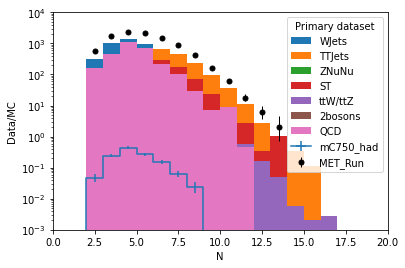

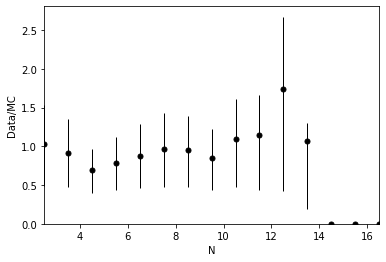

In [60]:
%matplotlib inline
output_data["number j"].label = 'Data/MC'
ax = hist.plot1d(output_sig["number j"], density=False, stack=False)
hist.plot1d(output_wjets["number j"], density=False, stack=True)
hist.plot1d(output_ttjets["number j"], density=False, stack=True)
hist.plot1d(output_znunu["number j"], density=False, stack=True)
hist.plot1d(output_st["number j"], density=False, stack=True)
hist.plot1d(output_ttwz["number j"], density=False, stack=True)
hist.plot1d(output_2b["number j"], density=False, stack=True)
hist.plot1d(output_qcd["number j"], density=False, stack=True)
ax=hist.plot1d(output_data["number j"], density=False, stack=False, error_opts = {'linestyle' : 'None', 'color' : 'black'})
ax.set_yscale('log')
ax.set_ylim(0.001,10000)
hist.plotratio(
num = output_data["number j"].sum("dataset"),
denom = (output_sig["number j"].sum("dataset")+output_wjets["number j"].sum("dataset")+output_ttjets["number j"].sum("dataset")+
      output_znunu["number j"].sum("dataset") + output_st["number j"].sum("dataset") + output_ttwz["number j"].sum("dataset")+
      output_2b["number j"].sum("dataset") + output_qcd["number j"].sum("dataset")),
error_opts={
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,},
unc='poisson-ratio')


/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


<AxesSubplot:xlabel='N', ylabel='Counts'>

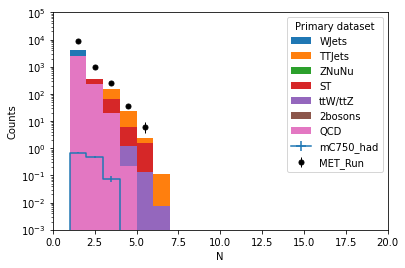

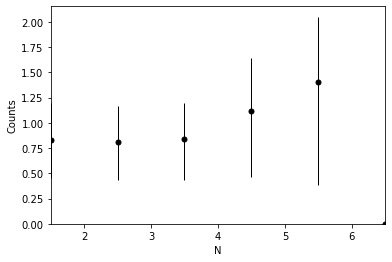

In [63]:
ax = hist.plot1d(output_sig["number b"], density=False)
hist.plot1d(output_wjets["number b"], density=False, stack=True)
hist.plot1d(output_ttjets["number b"], density=False, stack=True)
hist.plot1d(output_znunu["number b"], density=False, stack=True)
hist.plot1d(output_st["number b"], density=False, stack=True)
hist.plot1d(output_ttwz["number b"], density=False, stack=True)
hist.plot1d(output_2b["number b"], density=False, stack=True)
hist.plot1d(output_qcd["number b"], density=False, stack=True)
hist.plot1d(output_data["number b"], density=False, stack=False, error_opts = {'linestyle' : 'None', 'color':'black'})
ax.set_yscale('log')
ax.set_ylim(0.001,100000)
hist.plotratio(
num = output_data["number b"].sum("dataset"),
denom = (output_sig["number b"].sum("dataset")+output_wjets["number b"].sum("dataset")+output_ttjets["number b"].sum("dataset")+
      output_znunu["number b"].sum("dataset") + output_st["number b"].sum("dataset") + output_ttwz["number b"].sum("dataset")+
      output_2b["number b"].sum("dataset") + output_qcd["number b"].sum("dataset")),
error_opts={
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,},
unc='poisson-ratio')

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


<AxesSubplot:xlabel='N', ylabel='Counts'>

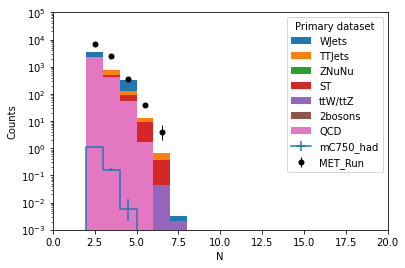

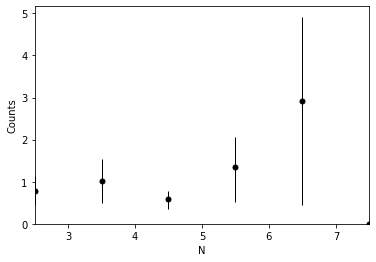

In [64]:
ax = hist.plot1d(output_sig["number fj"], density=False)
hist.plot1d(output_wjets["number fj"], density=False, stack=True)
hist.plot1d(output_ttjets["number fj"], density=False, stack=True)
hist.plot1d(output_znunu["number fj"], density=False, stack=True)
hist.plot1d(output_st["number fj"], density=False, stack=True)
hist.plot1d(output_ttwz["number fj"], density=False, stack=True)
hist.plot1d(output_2b["number fj"], density=False, stack=True)
hist.plot1d(output_qcd["number fj"], density=False, stack=True)
hist.plot1d(output_data["number fj"], density=False, stack=False, error_opts = {'linestyle' : 'None', 'color' : 'black'})
ax.set_yscale('log')
ax.set_ylim(0.001,100000)
hist.plotratio(
num = output_data["number fj"].sum("dataset"),
denom = (output_sig["number fj"].sum("dataset")+output_wjets["number fj"].sum("dataset")+output_ttjets["number fj"].sum("dataset")+
      output_znunu["number fj"].sum("dataset") + output_st["number fj"].sum("dataset") + output_ttwz["number fj"].sum("dataset")+
      output_2b["number fj"].sum("dataset") + output_qcd["number fj"].sum("dataset")),
error_opts={
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,},
unc='poisson-ratio')

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


<AxesSubplot:xlabel='N', ylabel='Counts'>

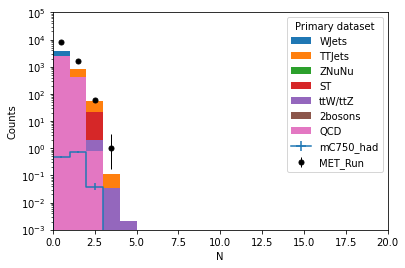

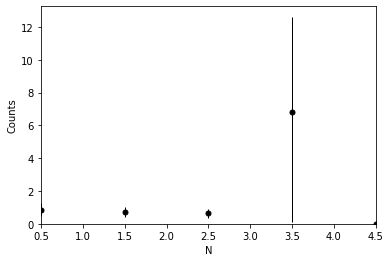

In [66]:
ax = hist.plot1d(output_sig["number h"], density=False)
hist.plot1d(output_wjets["number h"], density=False, stack=True)
hist.plot1d(output_ttjets["number h"], density=False, stack=True)
hist.plot1d(output_znunu["number h"], density=False, stack=True)
hist.plot1d(output_st["number h"], density=False, stack=True)
hist.plot1d(output_ttwz["number h"], density=False, stack=True)
hist.plot1d(output_2b["number h"], density=False, stack=True)
hist.plot1d(output_qcd["number h"], density=False, stack=True)
hist.plot1d(output_data["number h"], density=False, stack=False, error_opts = {'linestyle' : 'None', 'color' : 'black'})
ax.set_yscale('log')
ax.set_ylim(0.001,100000)
hist.plotratio(
num = output_data["number h"].sum("dataset"),
denom = (output_sig["number h"].sum("dataset")+output_wjets["number h"].sum("dataset")+output_ttjets["number h"].sum("dataset")+
      output_znunu["number h"].sum("dataset") + output_st["number h"].sum("dataset") + output_ttwz["number h"].sum("dataset")+
      output_2b["number h"].sum("dataset") + output_qcd["number h"].sum("dataset")),
error_opts={
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,},
unc='poisson-ratio')

(0.001, 100000)

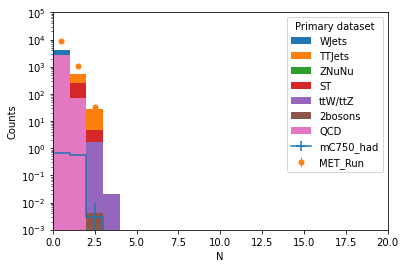

In [90]:
ax = hist.plot1d(output_sig["number w"], density=False)
hist.plot1d(output_wjets["number w"], density=False, stack=True)
hist.plot1d(output_ttjets["number w"], density=False, stack=True)
hist.plot1d(output_znunu["number w"], density=False, stack=True)
hist.plot1d(output_st["number w"], density=False, stack=True)
hist.plot1d(output_ttwz["number w"], density=False, stack=True)
hist.plot1d(output_2b["number w"], density=False, stack=True)
hist.plot1d(output_qcd["number w"], density=False, stack=True)
hist.plot1d(output_data["number w"], density=False, stack=False, error_opts = {'linestyle' : 'None', 'color' : 'black'})
ax.set_yscale('log')
ax.set_ylim(0.001,100000)
hist.plotratio(
num = output_data["number w"].sum("dataset"),
denom = (output_sig["number w"].sum("dataset")+output_wjets["number w"].sum("dataset")+output_ttjets["number w"].sum("dataset")+
      output_znunu["number w"].sum("dataset") + output_st["number w"].sum("dataset") + output_ttwz["number w"].sum("dataset")+
      output_2b["number w"].sum("dataset") + output_qcd["number w"].sum("dataset")),
error_opts={
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,},
unc='poisson-ratio')

(0.001, 100000)

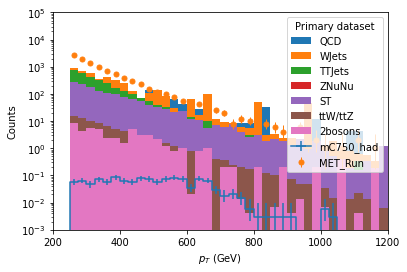

In [91]:
ax = hist.plot1d(output_qcd["met"], density=False, stack=True)
hist.plot1d(output_sig["met"], density=False)
hist.plot1d(output_wjets["met"], density=False, stack=True)
hist.plot1d(output_ttjets["met"], density=False, stack=True)
hist.plot1d(output_znunu["met"], density=False, stack=True)
hist.plot1d(output_st["met"], density=False, stack=True)
hist.plot1d(output_ttwz["met"], density=False, stack=True)
hist.plot1d(output_2b["met"], density=False, stack=True)
hist.plot1d(output_data["met data"], density=False, stack=False, error_opts = {'linestyle' : 'None'})
ax.set_yscale('log')
ax.set_ylim(0.001,100000)

(0.001, 10000)

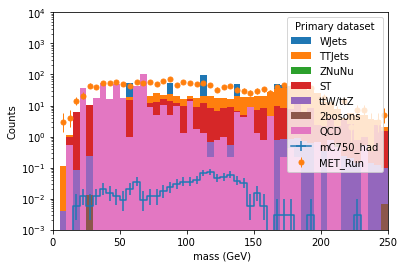

In [92]:
ax = hist.plot1d(output_sig["h mass"], density=False)
hist.plot1d(output_wjets["h mass"], density=False, stack=True)
hist.plot1d(output_ttjets["h mass"], density=False, stack=True)
hist.plot1d(output_znunu["h mass"], density=False, stack=True)
hist.plot1d(output_st["h mass"], density=False, stack=True)
hist.plot1d(output_ttwz["h mass"], density=False, stack=True)
hist.plot1d(output_2b["h mass"], density=False, stack=True)
hist.plot1d(output_qcd["h mass"], density=False, stack=True)
hist.plot1d(output_data["h mass data"], density=False, stack=False, error_opts = {'linestyle' : 'None'})
ax.set_yscale('log')
ax.set_ylim(0.001,10000)

(0.001, 1000000)

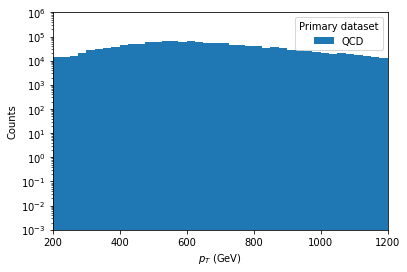

In [93]:
ax = hist.plot1d(output_qcd["ht"], density=False, stack=True)
ax.set_yscale('log')
ax.set_ylim(0.001,1000000)

(0.001, 10000000)

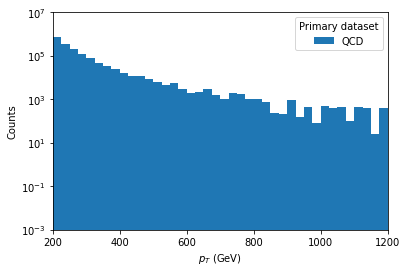

In [94]:
ax = hist.plot1d(output_qcd["met2"], density=False, stack=True)
ax.set_yscale('log')
ax.set_ylim(0.001,10000000)